#Дифференцированное обучение слоев

https://www.kaggle.com/c/dog-breed-identification/submit

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Oct 28 13:23:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
import pickle
import os
import sys
import numpy as np
import pandas as pd
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn as nn
from matplotlib import colors, pyplot as plt
%matplotlib inline

# Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=84e6be6470738b112d68ca5a9d00071a1997bbd3df41c9103829eb549956fb57
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
sys.path.insert(1, '/content/drive/MyDrive/Diplom')
from functions import *

In [ ]:
!unzip -q /content/drive/MyDrive/Diplom/dog-breed-identification.zip -d dogs

In [ ]:
!unzip -q /content/drive/MyDrive/Diplom/dogs_short_train.zip -d dogs_short

In [ ]:
d = create_labels('/content/dogs/labels.csv')


In [ ]:
TRAIN_DIR = Path('/content/dogs/train')
TEST_DIR = Path('/content/dogs/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

train_val_labels = [d[path.name] for path in train_val_files]

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
 stratify=train_val_labels)

train_dataset = DogsDataset(train_files, mode='train')

val_dataset = DogsDataset(val_files, mode='val')

test_dataset = DogsDataset(test_files, mode='test')

In [ ]:
TRAIN_DIR_SHORT = Path('/content/dogs_short')

train_val_files_short = sorted(list(TRAIN_DIR_SHORT.rglob('*.jpg')))

train_val_labels_short = [d[path.name] for path in train_val_files_short]

train_files_short, val_files_short = train_test_split(train_val_files_short, test_size=0.25, \
 stratify=train_val_labels_short)

train_dataset_short = DogsDataset(train_files_short, mode='train')

val_dataset_short = DogsDataset(val_files_short, mode='val')

# Обучение

In [ ]:
def initialize_and_train_model_diff_layers(model_name, output_num, epochs, batch_size, train_dataset, val_dataset, save_name):
  models_list = ["ResNet152", "VGG19", "DenseNet161", "EfficientNet"]
  found_lr =0.00005

  if model_name not in models_list:
       print(f"{model_name} is not correct; correct modes: {models_list}")
       raise NameError

  if (model_name == "ResNet152"):
    model = models.resnet152(pretrained=True)

    model.fc = nn.Sequential(nn.Linear(in_features=2048, out_features=1000, bias=True),
                             nn.Dropout(0.5),
                             nn.Linear(1000, 120, bias=True))
    
    opt = torch.optim.AdamW([{ 'params': model.fc.parameters(), 'lr': found_lr},
                         { 'params': model.layer4.parameters(), 'lr': found_lr / 3},
                         { 'params': model.layer3.parameters(), 'lr': found_lr / 10},
                         { 'params': model.layer2.parameters(), 'lr': found_lr / 50},
                         { 'params': model.layer1.parameters(), 'lr': found_lr / 100},
                         {'params': model.bn1.parameters(), 'lr': found_lr / 1000},
                         {'params': model.conv1.parameters(), 'lr': found_lr / 1000}],
                        lr=found_lr / 100, amsgrad=True)


  elif (model_name == "VGG19"):
    model = models.vgg19(pretrained = True)
    model.classifier[6] = nn.Linear(in_features=4096, out_features=120, bias=True)
    opt = torch.optim.Adam([
              { 'params': model.classifier.parameters(), 'lr': found_lr},
              { 'params': model.features[27:36].parameters(), 'lr': found_lr / 3},
              { 'params': model.features[18:27].parameters(), 'lr': found_lr / 10},
              { 'params': model.features[9:18].parameters(), 'lr': found_lr / 50},
              { 'params': model.features[0:9].parameters(), 'lr': found_lr / 100},
              ], lr=found_lr / 100)

  elif (model_name == "DenseNet161"):
    model = models.densenet161(pretrained=True)

    model.classifier = nn.Sequential(nn.Linear(2208, 128),
                              nn.BatchNorm1d(128),
                              nn.ReLU(),
                              nn.Dropout(p=0.5),
                              nn.Linear(128, 120))
    
    opt = torch.optim.AdamW([{ 'params': model.classifier.parameters(), 'lr': found_lr},
                         { 'params': model.features.norm5.parameters(), 'lr': found_lr / 3},
                         { 'params': model.features.denseblock4.parameters(), 'lr': found_lr / 10},
                         { 'params': model.features.denseblock3.parameters(), 'lr': found_lr / 50},
                         { 'params': model.features.denseblock2.parameters(), 'lr': found_lr / 100},
                         { 'params': model.features.denseblock1.parameters(), 'lr': found_lr / 1000},
                         { 'params': model.features.norm0.parameters(), 'lr': found_lr / 1000},
                         { 'params': model.features.conv0.parameters(), 'lr': found_lr / 1000}],
                        lr=found_lr / 100, amsgrad=True)
  
  else:
    model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=120)

    opt = torch.optim.AdamW([
                        { 'params': model._conv_stem.parameters(), 'lr': found_lr / 100},
                        { 'params': model._bn0.parameters(), 'lr': found_lr / 100},
                        { 'params': model._blocks[:11].parameters(), 'lr': found_lr / 50},
                        { 'params': model._blocks[11:22].parameters(), 'lr': found_lr / 50},
                        { 'params': model._blocks[22:33].parameters(), 'lr': found_lr / 3},
                        { 'params': model._blocks[33:44].parameters(), 'lr': found_lr / 3},
                        { 'params': model._bn1.parameters(), 'lr': found_lr},
                        { 'params': model._fc.parameters(), 'lr': found_lr},
                        ], lr=found_lr / 100, amsgrad=True)

  torch.cuda.empty_cache()
  
  history = train(train_dataset, val_dataset, model.cuda(), opt, epochs, batch_size, save_name)
  plot(history, model_name)
  return model

# ResNet 152

**Полный датасет**

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 3.5976272268765532


epoch:  10%|█         | 1/10 [08:40<1:18:02, 520.29s/it]

Saved model with val acc 0.6956181533646323

Epoch 001 train_loss: 3.5976   val_loss 1.8719 train_acc 0.3278 val_acc 0.6956
loss 0.6688683938955222


epoch:  20%|██        | 2/10 [17:17<1:09:09, 518.68s/it]

Saved model with val acc 0.8129890453834115

Epoch 002 train_loss: 0.6689   val_loss 0.6022 train_acc 0.7918 val_acc 0.8130
loss 0.29454635580121585


epoch:  30%|███       | 3/10 [25:57<1:00:34, 519.19s/it]

Saved model with val acc 0.814945226917058

Epoch 003 train_loss: 0.2945   val_loss 0.6168 train_acc 0.9033 val_acc 0.8149
loss 0.18443699191576376


epoch:  40%|████      | 4/10 [34:38<51:58, 519.77s/it]


Epoch 004 train_loss: 0.1844   val_loss 0.6471 train_acc 0.9343 val_acc 0.8142
loss 0.11064809465481024


epoch:  50%|█████     | 5/10 [43:17<43:17, 519.57s/it]

Saved model with val acc 0.8282472613458529

Epoch 005 train_loss: 0.1106   val_loss 0.6300 train_acc 0.9644 val_acc 0.8282
loss 0.06839138363504298


epoch:  60%|██████    | 6/10 [51:54<34:34, 518.74s/it]


Epoch 006 train_loss: 0.0684   val_loss 0.6413 train_acc 0.9773 val_acc 0.8239
loss 0.04727082226319472


epoch:  70%|███████   | 7/10 [1:00:34<25:57, 519.09s/it]


Epoch 007 train_loss: 0.0473   val_loss 0.7211 train_acc 0.9860 val_acc 0.8075
loss 0.03547714519181561


epoch:  80%|████████  | 8/10 [1:09:12<17:17, 518.68s/it]

Saved model with val acc 0.8352895148669797

Epoch 008 train_loss: 0.0355   val_loss 0.7268 train_acc 0.9909 val_acc 0.8353
loss 0.042134018209606154


epoch:  90%|█████████ | 9/10 [1:17:54<08:39, 519.82s/it]


Epoch 009 train_loss: 0.0421   val_loss 0.8343 train_acc 0.9892 val_acc 0.8130
loss 0.02263190956388282


epoch: 100%|██████████| 10/10 [1:26:36<00:00, 519.65s/it]



Epoch 010 train_loss: 0.0226   val_loss 0.8040 train_acc 0.9940 val_acc 0.8232


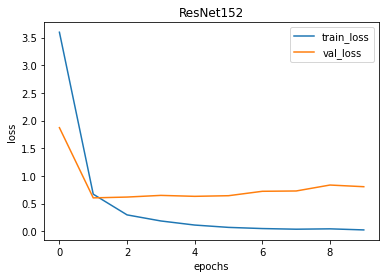

In [ ]:
save_name = '/content/DogsModelRESNET152_diff.pth'
model = initialize_and_train_model_diff_layers("ResNet152", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/resnet152_diff.csv', index = False)

Kaggle score 0.72972

**Сокращенный датасет**

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.460737582558913


epoch:  10%|█         | 1/10 [03:18<29:44, 198.31s/it]

Saved model with val acc 0.5357512953367876

Epoch 001 train_loss: 4.4607   val_loss 3.7323 train_acc 0.1179 val_acc 0.5358
loss 1.2379964600789926


epoch:  20%|██        | 2/10 [06:36<26:24, 198.09s/it]

Saved model with val acc 0.7575129533678756

Epoch 002 train_loss: 1.2380   val_loss 0.7828 train_acc 0.6929 val_acc 0.7575
loss 0.3948784160168834


epoch:  30%|███       | 3/10 [09:54<23:07, 198.20s/it]

Saved model with val acc 0.7626943005181347

Epoch 003 train_loss: 0.3949   val_loss 0.7679 train_acc 0.8828 val_acc 0.7627
loss 0.20259229107186671


epoch:  40%|████      | 4/10 [13:13<19:50, 198.33s/it]

Saved model with val acc 0.7709844559585491

Epoch 004 train_loss: 0.2026   val_loss 0.7646 train_acc 0.9357 val_acc 0.7710
loss 0.09918912038990241


epoch:  50%|█████     | 5/10 [16:31<16:32, 198.41s/it]

Saved model with val acc 0.7865284974093264

Epoch 005 train_loss: 0.0992   val_loss 0.7813 train_acc 0.9689 val_acc 0.7865
loss 0.058678451075346146


epoch:  60%|██████    | 6/10 [19:50<13:13, 198.42s/it]

Saved model with val acc 0.7917098445595855

Epoch 006 train_loss: 0.0587   val_loss 0.8058 train_acc 0.9834 val_acc 0.7917
loss 0.03957339820682611


epoch:  70%|███████   | 7/10 [23:08<09:55, 198.47s/it]

Saved model with val acc 0.8124352331606217

Epoch 007 train_loss: 0.0396   val_loss 0.7624 train_acc 0.9889 val_acc 0.8124
loss 0.008570325744427214


epoch:  80%|████████  | 8/10 [26:25<06:35, 197.98s/it]


Epoch 008 train_loss: 0.0086   val_loss 0.8990 train_acc 0.9983 val_acc 0.8124
loss 0.0062856860875885


epoch:  90%|█████████ | 9/10 [29:42<03:17, 197.69s/it]


Epoch 009 train_loss: 0.0063   val_loss 0.8617 train_acc 0.9983 val_acc 0.8093
loss 0.008099988112573925


epoch: 100%|██████████| 10/10 [33:00<00:00, 198.09s/it]

Saved model with val acc 0.8155440414507772

Epoch 010 train_loss: 0.0081   val_loss 0.8255 train_acc 0.9979 val_acc 0.8155


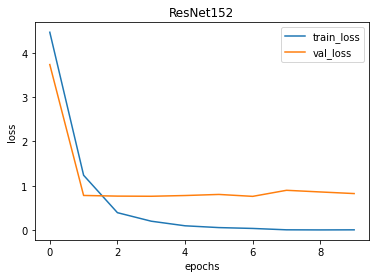

In [ ]:
save_name = '/content/DogsModelRESNET152_short_diff.pth'
model = initialize_and_train_model_diff_layers("ResNet152", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/resnet152_diff_short.csv', index = False)

Kaggle score 0.80292

# VGG19

**Полный датасет**

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 2.0488079675737385


epoch:  10%|█         | 1/10 [07:21<1:06:11, 441.33s/it]

Saved model with val acc 0.7664319248826291

Epoch 001 train_loss: 2.0488   val_loss 0.7853 train_acc 0.4940 val_acc 0.7664
loss 0.41604231335679515


epoch:  20%|██        | 2/10 [14:34<58:13, 436.66s/it]

Saved model with val acc 0.7683881064162754

Epoch 002 train_loss: 0.4160   val_loss 0.7615 train_acc 0.8666 val_acc 0.7684
loss 0.10373489114149974


epoch:  30%|███       | 3/10 [21:51<50:55, 436.49s/it]

Saved model with val acc 0.7816901408450705

Epoch 003 train_loss: 0.1037   val_loss 0.8027 train_acc 0.9693 val_acc 0.7817
loss 0.03864614248417654


epoch:  40%|████      | 4/10 [29:06<43:36, 436.12s/it]

Saved model with val acc 0.789906103286385

Epoch 004 train_loss: 0.0386   val_loss 0.8425 train_acc 0.9918 val_acc 0.7899
loss 0.018397770807287467


epoch:  50%|█████     | 5/10 [36:18<36:13, 434.75s/it]

Saved model with val acc 0.8012519561815337

Epoch 005 train_loss: 0.0184   val_loss 0.8597 train_acc 0.9961 val_acc 0.8013
loss 0.008502944542190798


epoch:  60%|██████    | 6/10 [43:37<29:04, 436.21s/it]


Epoch 006 train_loss: 0.0085   val_loss 0.9079 train_acc 0.9983 val_acc 0.7919
loss 0.010301617800289443


epoch:  70%|███████   | 7/10 [51:04<21:58, 439.44s/it]


Epoch 007 train_loss: 0.0103   val_loss 0.8408 train_acc 0.9973 val_acc 0.7966
loss 0.005487265307801279


epoch:  80%|████████  | 8/10 [58:10<14:30, 435.29s/it]


Epoch 008 train_loss: 0.0055   val_loss 0.9522 train_acc 0.9987 val_acc 0.7950
loss 0.004234099513500615


epoch:  90%|█████████ | 9/10 [1:05:20<07:13, 433.74s/it]


Epoch 009 train_loss: 0.0042   val_loss 0.9598 train_acc 0.9988 val_acc 0.7981
loss 0.004852889329092973


epoch: 100%|██████████| 10/10 [1:12:37<00:00, 435.78s/it]



Epoch 010 train_loss: 0.0049   val_loss 0.9366 train_acc 0.9987 val_acc 0.7985


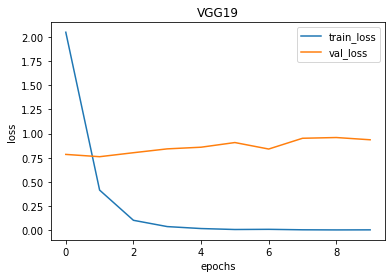

In [ ]:
save_name = '/content/DogsModelVGG19_diff.pth'
model = initialize_and_train_model_diff_layers("VGG19", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/vgg19_diff.csv', index = False)

Kaggle score 0.86622

**Сокращенный датасет**

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.342074809232688


epoch:  10%|█         | 1/10 [02:40<24:04, 160.54s/it]

Saved model with val acc 0.682901554404145

Epoch 001 train_loss: 3.3421   val_loss 1.1682 train_acc 0.2687 val_acc 0.6829
loss 0.555206351878732


epoch:  20%|██        | 2/10 [05:21<21:26, 160.76s/it]

Saved model with val acc 0.7212435233160621

Epoch 002 train_loss: 0.5552   val_loss 0.9822 train_acc 0.8402 val_acc 0.7212
loss 0.08500352755374434


epoch:  30%|███       | 3/10 [08:02<18:45, 160.82s/it]

Saved model with val acc 0.7316062176165803

Epoch 003 train_loss: 0.0850   val_loss 0.9941 train_acc 0.9768 val_acc 0.7316
loss 0.01978204817347548


epoch:  40%|████      | 4/10 [10:42<16:03, 160.64s/it]

Saved model with val acc 0.7430051813471502

Epoch 004 train_loss: 0.0198   val_loss 1.0377 train_acc 0.9959 val_acc 0.7430
loss 0.008869170119636853


epoch:  50%|█████     | 5/10 [13:21<13:19, 159.96s/it]


Epoch 005 train_loss: 0.0089   val_loss 1.0957 train_acc 0.9979 val_acc 0.7389
loss 0.007704746195409488


epoch:  60%|██████    | 6/10 [16:01<10:40, 160.07s/it]

Saved model with val acc 0.7440414507772021

Epoch 006 train_loss: 0.0077   val_loss 1.0325 train_acc 0.9990 val_acc 0.7440
loss 0.004098363582939773


epoch:  70%|███████   | 7/10 [18:42<08:01, 160.34s/it]

Saved model with val acc 0.7512953367875648

Epoch 007 train_loss: 0.0041   val_loss 1.0631 train_acc 0.9993 val_acc 0.7513
loss 0.0005181464303717537


epoch:  80%|████████  | 8/10 [21:20<05:19, 159.65s/it]


Epoch 008 train_loss: 0.0005   val_loss 1.1117 train_acc 1.0000 val_acc 0.7503
loss 0.00033613492667586135


epoch:  90%|█████████ | 9/10 [24:01<02:40, 160.01s/it]

Saved model with val acc 0.7523316062176165

Epoch 009 train_loss: 0.0003   val_loss 1.1464 train_acc 1.0000 val_acc 0.7523
loss 0.0002428117791829337


epoch: 100%|██████████| 10/10 [26:41<00:00, 160.12s/it]

Saved model with val acc 0.7544041450777201

Epoch 010 train_loss: 0.0002   val_loss 1.1754 train_acc 1.0000 val_acc 0.7544


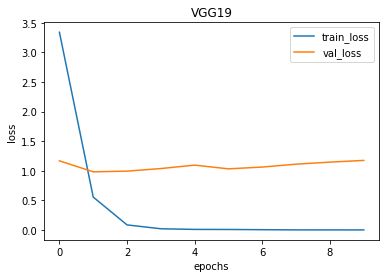

In [ ]:
save_name = '/content/DogsModelVGG19_diff_short.pth'
model = initialize_and_train_model_diff_layers("VGG19", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/vgg19_diff_short.csv', index = False)

Kaggle score 1.17212

# DenseNet161

**Полный датасет**

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.527617918676849


epoch:  10%|█         | 1/10 [09:07<1:22:06, 547.44s/it]

Saved model with val acc 0.289906103286385

Epoch 001 train_loss: 4.5276   val_loss 4.0037 train_acc 0.0620 val_acc 0.2899
loss 1.7075184151363099


epoch:  20%|██        | 2/10 [18:08<1:12:31, 543.93s/it]

Saved model with val acc 0.715962441314554

Epoch 002 train_loss: 1.7075   val_loss 0.9592 train_acc 0.5767 val_acc 0.7160
loss 0.6705674074226716


epoch:  30%|███       | 3/10 [27:09<1:03:18, 542.60s/it]

Saved model with val acc 0.7672143974960877

Epoch 003 train_loss: 0.6706   val_loss 0.7548 train_acc 0.8000 val_acc 0.7672
loss 0.47656139977880846


epoch:  40%|████      | 4/10 [36:12<54:14, 542.41s/it]

Saved model with val acc 0.7824726134585289

Epoch 004 train_loss: 0.4766   val_loss 0.7257 train_acc 0.8600 val_acc 0.7825
loss 0.36152132410636745


epoch:  50%|█████     | 5/10 [45:13<45:10, 542.02s/it]

Saved model with val acc 0.7918622848200313

Epoch 005 train_loss: 0.3615   val_loss 0.7025 train_acc 0.8920 val_acc 0.7919
loss 0.28102618447528505


epoch:  60%|██████    | 6/10 [54:13<36:05, 541.41s/it]

Saved model with val acc 0.7981220657276995

Epoch 006 train_loss: 0.2810   val_loss 0.6673 train_acc 0.9178 val_acc 0.7981
loss 0.2087204992740048


epoch:  70%|███████   | 7/10 [1:03:12<27:01, 540.51s/it]


Epoch 007 train_loss: 0.2087   val_loss 0.6909 train_acc 0.9448 val_acc 0.7946
loss 0.15751633607191265


epoch:  80%|████████  | 8/10 [1:12:11<17:59, 539.95s/it]

Saved model with val acc 0.8035993740219093

Epoch 008 train_loss: 0.1575   val_loss 0.6906 train_acc 0.9616 val_acc 0.8036
loss 0.11182222261678883


epoch:  90%|█████████ | 9/10 [1:21:09<08:59, 539.62s/it]


Epoch 009 train_loss: 0.1118   val_loss 0.7414 train_acc 0.9730 val_acc 0.7903
loss 0.07903369357714664


epoch: 100%|██████████| 10/10 [1:30:08<00:00, 540.89s/it]



Epoch 010 train_loss: 0.0790   val_loss 0.7642 train_acc 0.9845 val_acc 0.7926


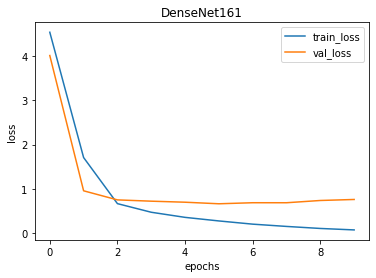

In [ ]:
save_name = '/content/DogsModelDenseNet161_diff.pth'
model = initialize_and_train_model_diff_layers("DenseNet161", 120, 10, 32, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/densenet161_diff.csv', index = False)

Kaggle score 0.73347

**Сокращенный датасет**

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss 4.764045727203496


epoch:  10%|█         | 1/10 [03:23<30:33, 203.73s/it]

Saved model with val acc 0.07668393782383419

Epoch 001 train_loss: 4.7640   val_loss 4.4815 train_acc 0.0225 val_acc 0.0767
loss 3.6419890665579304


epoch:  20%|██        | 2/10 [06:45<27:02, 202.84s/it]

Saved model with val acc 0.36062176165803106

Epoch 002 train_loss: 3.6420   val_loss 2.6093 train_acc 0.2203 val_acc 0.3606
loss 1.6537034031761138


epoch:  30%|███       | 3/10 [10:08<23:37, 202.48s/it]

Saved model with val acc 0.5761658031088083

Epoch 003 train_loss: 1.6537   val_loss 1.4924 train_acc 0.5754 val_acc 0.5762
loss 0.8491742449347573


epoch:  40%|████      | 4/10 [13:30<20:13, 202.32s/it]

Saved model with val acc 0.6704663212435232

Epoch 004 train_loss: 0.8492   val_loss 1.1756 train_acc 0.7673 val_acc 0.6705
loss 0.553888136173185


epoch:  50%|█████     | 5/10 [16:51<16:50, 202.16s/it]

Saved model with val acc 0.689119170984456

Epoch 005 train_loss: 0.5539   val_loss 1.1033 train_acc 0.8506 val_acc 0.6891
loss 0.3741285145117864


epoch:  60%|██████    | 6/10 [20:13<13:28, 202.07s/it]

Saved model with val acc 0.7025906735751295

Epoch 006 train_loss: 0.3741   val_loss 1.0915 train_acc 0.9025 val_acc 0.7026
loss 0.2600331287083949


epoch:  70%|███████   | 7/10 [23:35<10:05, 201.94s/it]


Epoch 007 train_loss: 0.2600   val_loss 1.1455 train_acc 0.9429 val_acc 0.6860
loss 0.181273853764412


epoch:  80%|████████  | 8/10 [26:57<06:44, 202.08s/it]

Saved model with val acc 0.7077720207253886

Epoch 008 train_loss: 0.1813   val_loss 1.0951 train_acc 0.9578 val_acc 0.7078
loss 0.1159979722476764


epoch:  90%|█████████ | 9/10 [30:19<03:22, 202.07s/it]


Epoch 009 train_loss: 0.1160   val_loss 1.0915 train_acc 0.9813 val_acc 0.7057
loss 0.09221706425005964


epoch: 100%|██████████| 10/10 [33:42<00:00, 202.22s/it]

Saved model with val acc 0.7150259067357513

Epoch 010 train_loss: 0.0922   val_loss 1.1158 train_acc 0.9865 val_acc 0.7150


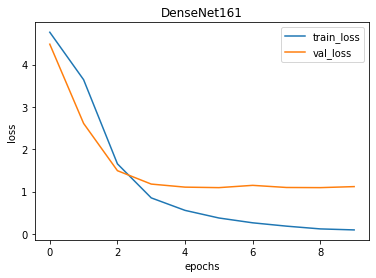

In [ ]:
save_name = '/content/DogsModelDenseNet161_diff_short.pth'
model = initialize_and_train_model_diff_layers("DenseNet161", 120, 10, 32, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/densenet161_diff_short.csv', index = False)

Kaggle score 1.04323

# EfficientNet B6

**Полный датасет**

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b6-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b6


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.654423409642857


epoch:  10%|█         | 1/10 [12:35<1:53:17, 755.25s/it]

Saved model with val acc 0.3841940532081377

Epoch 001 train_loss: 4.6544   val_loss 4.4695 train_acc 0.0823 val_acc 0.3842
loss 1.922174531067441


epoch:  20%|██        | 2/10 [24:57<1:39:40, 747.55s/it]

Saved model with val acc 0.7652582159624414

Epoch 002 train_loss: 1.9222   val_loss 0.8124 train_acc 0.6323 val_acc 0.7653
loss 0.45279986275315764


epoch:  30%|███       | 3/10 [37:17<1:26:50, 744.32s/it]

Saved model with val acc 0.7820813771517997

Epoch 003 train_loss: 0.4528   val_loss 0.7022 train_acc 0.8643 val_acc 0.7821
loss 0.18817317937256586


epoch:  40%|████      | 4/10 [49:38<1:14:18, 743.01s/it]

Saved model with val acc 0.7902973395931142

Epoch 004 train_loss: 0.1882   val_loss 0.7225 train_acc 0.9443 val_acc 0.7903
loss 0.0833054526829809


epoch:  50%|█████     | 5/10 [1:02:05<1:02:01, 744.21s/it]


Epoch 005 train_loss: 0.0833   val_loss 0.7605 train_acc 0.9747 val_acc 0.7856
loss 0.0345752785630945


epoch:  60%|██████    | 6/10 [1:14:26<49:32, 743.12s/it]

Saved model with val acc 0.7961658841940532

Epoch 006 train_loss: 0.0346   val_loss 0.8376 train_acc 0.9920 val_acc 0.7962
loss 0.015744292238854044


epoch:  70%|███████   | 7/10 [1:26:48<37:08, 742.78s/it]

Saved model with val acc 0.7992957746478874

Epoch 007 train_loss: 0.0157   val_loss 0.8881 train_acc 0.9967 val_acc 0.7993
loss 0.00870444726866728


epoch:  80%|████████  | 8/10 [1:39:09<24:44, 742.37s/it]


Epoch 008 train_loss: 0.0087   val_loss 0.9295 train_acc 0.9992 val_acc 0.7966
loss 0.00778866333513802


epoch:  90%|█████████ | 9/10 [1:51:35<12:23, 743.32s/it]


Epoch 009 train_loss: 0.0078   val_loss 0.9635 train_acc 0.9984 val_acc 0.7981
loss 0.005468097253868381


epoch: 100%|██████████| 10/10 [2:03:59<00:00, 743.93s/it]



Epoch 010 train_loss: 0.0055   val_loss 0.9949 train_acc 0.9991 val_acc 0.7973


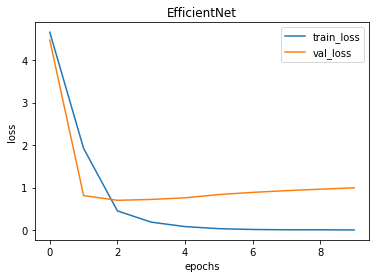

In [ ]:
save_name = '/content/EfficientNetB6_diff.pth'
model = initialize_and_train_model_diff_layers("EfficientNet", 120, 10, 16, train_dataset, val_dataset, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/effnet_diff.csv', index = False)

Kaggle score 0.89958

**Сокращенный датасет**

Loaded pretrained weights for efficientnet-b6


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 4.760110135559884


epoch:  10%|█         | 1/10 [04:45<42:52, 285.89s/it]

Saved model with val acc 0.08290155440414507

Epoch 001 train_loss: 4.7601   val_loss 4.6920 train_acc 0.0204 val_acc 0.0829
loss 4.536686413845416


epoch:  20%|██        | 2/10 [09:28<37:49, 283.71s/it]

Saved model with val acc 0.34093264248704663

Epoch 002 train_loss: 4.5367   val_loss 4.2740 train_acc 0.3126 val_acc 0.3409
loss 2.219351757116832


epoch:  30%|███       | 3/10 [14:10<33:01, 283.01s/it]

Saved model with val acc 0.7088082901554403

Epoch 003 train_loss: 2.2194   val_loss 1.1300 train_acc 0.5778 val_acc 0.7088
loss 0.5279314512204003


epoch:  40%|████      | 4/10 [18:52<28:15, 282.61s/it]

Saved model with val acc 0.7502590673575129

Epoch 004 train_loss: 0.5279   val_loss 0.8798 train_acc 0.8568 val_acc 0.7503
loss 0.18543517413867294


epoch:  50%|█████     | 5/10 [23:35<23:34, 282.88s/it]

Saved model with val acc 0.7647668393782383

Epoch 005 train_loss: 0.1854   val_loss 0.8445 train_acc 0.9516 val_acc 0.7648
loss 0.07195076645631472


epoch:  60%|██████    | 6/10 [28:18<18:51, 282.90s/it]

Saved model with val acc 0.7730569948186529

Epoch 006 train_loss: 0.0720   val_loss 0.8790 train_acc 0.9848 val_acc 0.7731
loss 0.026283065535973135


epoch:  70%|███████   | 7/10 [33:01<14:08, 282.85s/it]

Saved model with val acc 0.7772020725388601

Epoch 007 train_loss: 0.0263   val_loss 0.8986 train_acc 0.9965 val_acc 0.7772
loss 0.024589694389122774


epoch:  80%|████████  | 8/10 [37:43<09:25, 282.80s/it]


Epoch 008 train_loss: 0.0246   val_loss 0.9138 train_acc 0.9959 val_acc 0.7710
loss 0.014496303734113238


epoch:  90%|█████████ | 9/10 [42:26<04:42, 282.59s/it]


Epoch 009 train_loss: 0.0145   val_loss 0.9968 train_acc 0.9976 val_acc 0.7668
loss 0.006089575965483035


epoch: 100%|██████████| 10/10 [47:07<00:00, 282.72s/it]



Epoch 010 train_loss: 0.0061   val_loss 0.9629 train_acc 0.9993 val_acc 0.7741


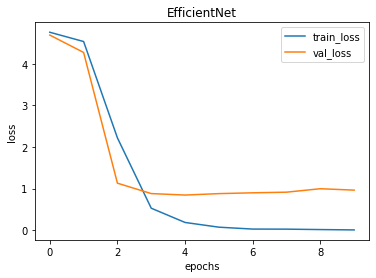

In [ ]:
save_name = '/content/EfficientNetB6_diff_short.pth'
model = initialize_and_train_model_diff_layers("EfficientNet", 120, 10, 16, train_dataset_short, val_dataset_short, save_name)

In [ ]:
res = make_prediction(save_name, model, test_files)
res.to_csv('/content/drive/MyDrive/Diplom/effnet_diff_short.csv', index = False)

Kaggle score 0.93136